In [112]:
from pyGDM2 import structures
from pyGDM2 import fields
from pyGDM2 import core
from pyGDM2 import propagators
from pyGDM2 import tools
from pyGDM2 import linear
from pyGDM2 import visu

import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from ase.io import read

sys.path.insert(0, 'Light/'); sys.path.insert(0, 'Building/')
from Light import Epsilon_ExpClass #For optical response with the pygdm package 

In [113]:
Strut = read("Ag_344.xyz")
ele = Strut.get_chemical_symbols()
Ele = list(set(ele))
Strut.positions -= Strut.get_center_of_mass()
xyz = Strut.positions
g = xyz
m = len(g)*[getattr(Epsilon_ExpClass, Ele[0])()]
Struct = structures.struct(2.88, g, m)

structure initialization - automatic mesh detection: hex
structure initialization - consistency check: 344/344 dipoles valid


In [ ]:
field_generator = fields.plane_wave
wavelengths = np.linspace(300, 800, 201)

kwargs_L = dict(inc_angle=180, E_s=1, E_p=1, phase_Es=[-np.pi/2]) #Defines the left circularly polarized light coming in the xy plane along z in the positive direction
efield_L = fields.efield(field_generator, wavelengths=wavelengths, kwargs=kwargs_L)
dyads = propagators.DyadsQuasistatic123(n1=1) #Vacuum
sim_L = core.simulation(Struct, efield_L, dyads)
sim_L.scatter(verbose=False)


kwargs_R = dict(inc_angle=180, E_s=1, E_p=1, phase_Es=[ np.pi/2]) #Defines the right circularly polarized light coming in the xy plane along z in the positive direction
efield_R = fields.efield(field_generator, wavelengths=wavelengths, kwargs=kwargs_R)
dyads = propagators.DyadsQuasistatic123(n1=1) #Vacuum
sim_R = core.simulation(Struct, efield_R, dyads)
sim_R.scatter(verbose=False)

1

config 0 : {'E_p': 1, 'E_s': 1, 'inc_angle': 180, 'phase_Es': -1.5707963267948966}
Significant local maxima:
Value: 528.3872814491515, Index: 19
Value: 1086.3384227342667, Index: 25
Value: 3720.0207199141505, Index: 39


Text(0, 0.5, '$\\sigma_{ext}$ (nm$^2$)')

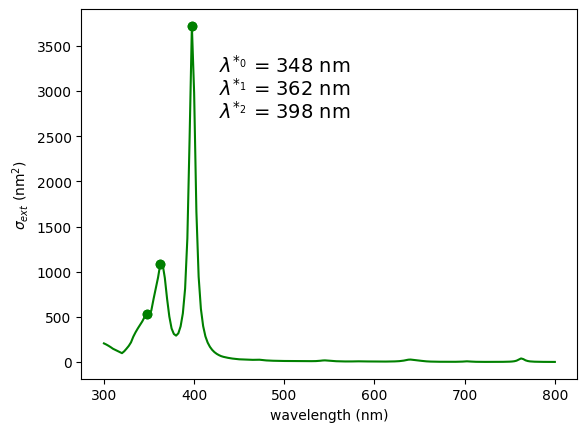

In [ ]:
field_kwargs_L = tools.get_possible_field_params_spectra(sim_L)
for i, conf in enumerate(field_kwargs_L):
    print("config", i, ":", conf)
wl, spectrum_L = tools.calculate_spectrum(sim_L,field_kwargs_L[0] , linear.extinct)

spectrum_L = spectrum_L.T

peaks, _ = find_peaks(spectrum_L[0], height=0.05*np.amax(spectrum_L[0]))
# Print the significant local maxima
print("Significant local maxima:")
for peak in peaks:
    print(f"Value: {spectrum_L[0][peak]}, Index: {peak}")

plt.plot(wl, spectrum_L[0], 'g-', label='ext.')
plt.plot(wl[peaks], spectrum_L[0][peaks], "o", color = 'g')
for i,peak in enumerate(peaks):
    plt.text(500, 0.85*np.amax(spectrum_L[0])-250*i, "$\lambda^{*_{%s}}$ = " f'{wl[peak]:.0f} nm' %(i), ha='center', va='bottom', fontsize = 14)

plt.plot(wl[peaks], spectrum_L[0][peaks], "o", color='g', label='peaks')
plt.xlabel("wavelength (nm)")
plt.ylabel("$\sigma_{ext}$ (nm$^2$)")



In [351]:
def cmnp_plot(
              wl_target = 400, 
              z_probe = 0,
              projection = "XY"
              ):
    
    idx = tools.get_closest_field_index(sim_L, dict(wavelength=wl_target))

    wl, Cspec_L = tools.calculate_spectrum(sim_L, 0, linear.optical_chirality, r_probe=[[0,0,z_probe]])
    C_spec_L = Cspec_L.T
    
    r_probe_L = tools.generate_NF_map(-40,+40,201, -40,40,201, Z0=z_probe)
    C_L_t = linear.optical_chirality(sim_L, idx, r_probe_L, which_field='t')
    Es_L, Et_L, E0_L, Bs_L, Bt_L, B0_L  = linear.nearfield(sim_L, idx, r_probe=r_probe_L, which_fields=['es', 'et', 'e0', 'bs', 'bt', 'b0'])

    wl, Cspec_R = tools.calculate_spectrum(sim_R, 0, linear.optical_chirality, r_probe=[[0,0,z_probe]])
    C_spec_R = Cspec_R.T
    
    r_probe_R = tools.generate_NF_map(-40,+40,201, -40,40,201, Z0=z_probe)
    C_R_t = linear.optical_chirality(sim_R, idx, r_probe_R, which_field='t')
    Es_R, Et_R, E0_R, Bs_R, Bt_R, B0_R  = linear.nearfield(sim_R, idx, r_probe=r_probe_R, which_fields=['es', 'et', 'e0', 'bs', 'bt', 'b0'])


    fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
    fig.set_size_inches(10, 10)
    fig.subplots_adjust(hspace=0.0, wspace=0.0)
    
    im_EL = visu.vectorfield_color(Et_L, show=0, ax=axs[0,0], cmap="seismic", vmin=0, vmax = 100, projection=projection)
    visu.structure_contour(sim_L, color='k', show=0, lw = 10, ax=axs[0,0], projection=projection)
    im_CL = visu.scalarfield(C_L_t, cmap='seismic', show=0, interpolation='nearest',  vmin=-5, vmax=5, ax=axs[1,0], projection=projection)
    visu.structure_contour(sim_L, color='k', show=0, lw = 10, ax=axs[1,0], projection=projection)
    
    im_ER = visu.vectorfield_color(Et_R, show=0, ax=axs[0,1], cmap='seismic', vmin=0, vmax = 100, projection=projection)
    visu.structure_contour(sim_R, color='k', show=0, lw = 10, ax=axs[0,1], projection=projection)
    im_CR = visu.scalarfield(C_R_t, cmap='seismic', show=0, interpolation='nearest', vmin=-5, vmax=5, ax=axs[1,1], projection=projection)
    visu.structure_contour(sim_R, color='k', show=0, lw = 10, ax=axs[1,1], projection=projection)

    axs[0,1].yaxis.set_label_position("right")
    axs[0,1].yaxis.tick_right()
    
    axs[1,1].yaxis.set_label_position("right")
    axs[1,1].yaxis.tick_right()
    
    axs[0,0].xaxis.set_label_position("top")
    axs[0,0].xaxis.tick_top()
    
    axs[0,1].xaxis.set_label_position("top")
    axs[0,1].xaxis.tick_top()
    
    axs[0,1].tick_params(labeltop=True)
    axs[0,0].tick_params(labeltop=True)
    
    axs[0,1].tick_params(labelright=True)
    axs[1,1].tick_params(labelright=True)
    
    #fig.subplots_adjust(wspace=0.025, hspace=0.025)
    cbar_ax_cpl = fig.add_axes([0.125, 0.96, 0.725, 0.02])
    cax_cpl = fig.colorbar(im_ER, cax=cbar_ax_cpl,  orientation='horizontal')    
    cbar_ax_cpl.xaxis.set_ticks_position('top')
    
    cbar_ax_e = fig.add_axes([0.125, 0.025, 0.725, 0.02])
    cax_e = fig.colorbar(im_CR, cax=cbar_ax_e, orientation='horizontal')
    cbar_ax_e.xaxis.set_ticks_position('bottom')
    
    
    axs[0,0].text(0.5, 1.1, 'Left CPL', ha='center', va='center', fontsize = 16, transform=axs[0,0].transAxes)
    axs[0,1].text(0.5, 1.1, 'Right CPL', ha='center', va='center', fontsize = 16, transform=axs[0,1].transAxes)
    
    fig.text(0.5, 1.01,'$\mathcal{E}_{t}$ (a.u.)', verticalalignment='center', horizontalalignment='center', fontsize = 16)
    fig.text(0.5, -0.01,'$\mathcal{C}_{t}$ (a.u.)', verticalalignment='center', horizontalalignment='center', fontsize = 16)
    axs[0,0].text(-45,50, f'$\lambda$ = ' f'{wl[peak]:.0f} nm', fontsize = 14)
    axs[0,1].text(17.5,50, f'z = {z_probe} nm', fontsize = 14)
    axs = axs.T.flatten()
    for i,ax in enumerate(axs):
        ax.set_aspect('equal')

/home/robert/MyEnv/lib/python3.10/site-packages/pyGDM2/linear.py:617: UserWarning: No H-values inside structure calculated. Setting internal magnetic field zero. Please run 'scatter' with the according parameter.
  warnings.warn("No H-values inside structure calculated. Setting internal magnetic field zero. " +


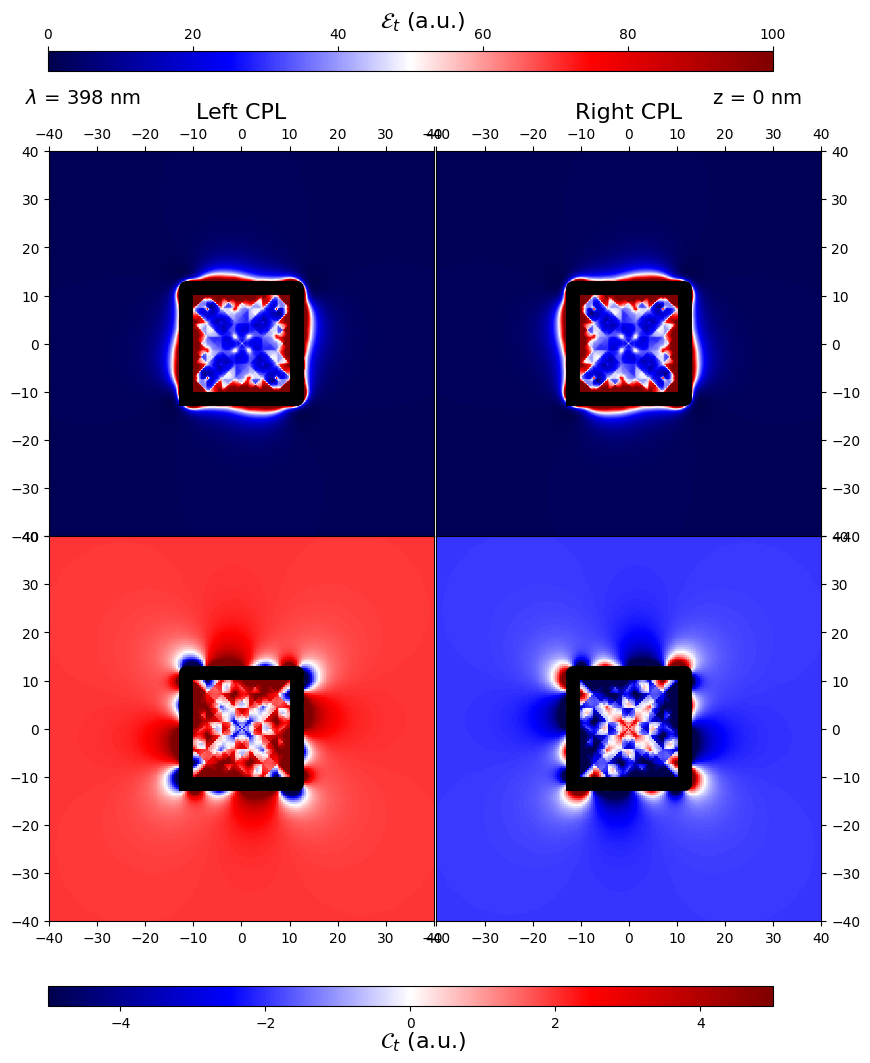

In [352]:
cmnp_plot(wl[peaks][1],0)